**Tema: Valor de vida de los clientes de un negocio de ventas online**


**Autor: Francisco Moyano Escalera**

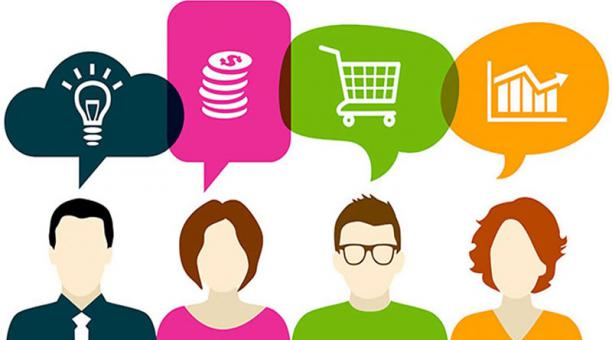

**1) Introducción**

El valor de la vida del cliente o Customer Lifetime Value (CLV) es una métrica que indica los ingresos totales que una empresa puede esperar obtener de la cuenta de un cliente, dicho con otras palabras, representa el total de dinero que se espera que un cliente gaste en el negocio, a lo largo de su vida. El valor de cada cliente se calcula teniendo en cuenta el número de compras efectuadas, su valor o la media del mismo y tomando como referencia un periodo de tiempo.
Esto es importante porque ayuda a tomar decisiones sobre cuánto invertir en la adquisición de nuevo clientes y en la retención de los existentes (los de mayor valor).


**2) Objetivo**

Desarrollar modelos de machine learning para clasificar a los clientes en base a su a su valor de vida para la empresa.

**3) Fuente de datos**

La base de datos utilizada en el presente proyecto cuenta con las siguientes columnas/características:

* N_Factura: número correspondiente a la factura de venta.
* N_Stock: número de stock de los producto vendido.
* Descripcion: descripción/nombre del producto vendido.
* Cantidad: cantidad vendida del producto.
* F_Factura: fecha de la factura.
* Precio: precio unitario de los prudctos.
* ID_Cliente: número identificatorio de cada cliente.
* Pais: país de procedencia de los clientes.

**4) Solución planteada**

Para el desarrollo de este proyecto se llevarán a cabo, en términos generales, los siguientes pasos:

1) Se asignará a un segmento de valor (valor alto, medio y bajo) a cada cliente en base a sus puntajes de recencia, frecuencia e ingresos generados a la empresa, mediante el algoritmo de aprendizaje no supervisado K-medias, utilizando los datos de la base de datos con los clientes del Reino Unido en sus primeros 3 meses de actividad.

2) Se clasificará a cada cliente de acuerdo a su valor de vida para la empresa (alto, medio, bajo), utilizando los datos de la base de datos con los 6 meses restantes de actividad, lo cual servirá como variable objetivo para el desarollo de los modelos.

3) Se llevarán a cabo una serie de modelos de aprendizaje supervisado, utilizando algoritmos de clasificación, con el fin de predecir la clasificación del CLV de los clientes.

**5) Adquisición de datos**

In [1]:
# Se realiza la conexión con Google Drive, en donde se encuentra almacenada la base de datos:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Se importan las librerías a utilizar:
# ============================================================================================================================================
! pip install chart_studio
import warnings
warnings.filterwarnings("ignore")
# ============================================================================================================================================
# Tratamiento y exploración de datos:
from datetime import datetime, timedelta,date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
# ============================================================================================================================================
# Preprocesamiento y modelado
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.7 MB/s 


In [3]:
# Se incorporan las siguientes las librerías:
from __future__ import division
import chart_studio.plotly 
import plotly.offline as pyoff
import plotly.graph_objs as go

In [352]:
# Se carga la base de datos en un dataframe:
data = pd.read_excel("/content/drive/MyDrive/Proyectos/Marketing/Online Retail.xlsx")


In [353]:
# Se imprime el encabezado del conjunto de datos:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [354]:
# Se observa en detalle los nombres de las columnas y los tipos de datos:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


El dataframe está compuesto por 541.909 filas y  8 columnas, de las cuales 3 son cuantitatitas ("Quantity", "UnitPrice" y "CustomerID"), 1 con datos de tipo date ("InvoiceDate") y las 4 restantes son cualitativas.

**6) Limpieza y transformación de datos (Data Wrangling)**

In [355]:
# Se determina si el dataframe tiene datos faltantes:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum() / data.isnull().count() * 100)
percent.sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ["Total Faltantes", "Porcentaje"])
missing_data

,Total Faltantes,Porcentaje
CustomerID,135080,24.926694
Description,1454,0.268311
InvoiceNo,0,0.000000
StockCode,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
Country,0,0.000000


Existen dos columnas con valores nulos (NaN), sin embargo ninguna presenta un porcentaje alto de datos faltantes que obligue a eliminarlas.

In [356]:
# Se analiza si el dataframe tiene datos duplicados:
duplicados = data.duplicated(keep= False) # Con keep=False se mantienen todos los duplicados
data[duplicados].sort_values(by="CustomerID") # Se ordenan las filas por Id para visualizar bien los duplicados

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
395388,571034,23239,SET OF 4 KNICK KNACK TINS POPPIES,6,2011-10-13 12:47:00,4.15,12359.0,Cyprus
395410,571034,23239,SET OF 4 KNICK KNACK TINS POPPIES,6,2011-10-13 12:47:00,4.15,12359.0,Cyprus
395442,571034,23494,VINTAGE DOILY DELUXE SEWING KIT,3,2011-10-13 12:47:00,5.95,12359.0,Cyprus
395443,571034,23494,VINTAGE DOILY DELUXE SEWING KIT,3,2011-10-13 12:47:00,5.95,12359.0,Cyprus
395455,571034,23245,SET OF 3 REGENCY CAKE TINS,4,2011-10-13 12:47:00,4.95,12359.0,Cyprus
...,...,...,...,...,...,...,...,...
424915,573290,23396,LE JARDIN BOTANIQUE CUSHION COVER,1,2011-10-28 14:51:00,3.75,NaN,Switzerland
483004,577489,23221,REINDEER HEART DECORATION SILVER,1,2011-11-20 12:07:00,0.83,NaN,United Kingdom
483010,577489,23221,REINDEER HEART DECORATION SILVER,1,2011-11-20 12:07:00,0.83,NaN,United Kingdom
514740,579744,23010,CIRCUS PARADE BABY GIFT SET,1,2011-11-30 14:38:00,16.95,NaN,United Kingdom


In [357]:
# Se eliminan los registros duplicados: 
data.drop_duplicates(inplace= True)

In [358]:
# Se modifican los nombres de las variables originales para facilitar el análisis:
data = data.rename(columns={"InvoiceNo": "N_Factura", 
                            "StockCode": "N_Stock",
                            "Description": "Descripcion",
                            "Quantity": "Cantidad",
                            "InvoiceDate": "F_Factura",
                            "UnitPrice": "Precio",
                            "CustomerID": "ID_Cliente",
                            "Country": "Pais"})
data.columns

Index(['N_Factura', 'N_Stock', 'Descripcion', 'Cantidad', 'F_Factura',
       'Precio', 'ID_Cliente', 'Pais'],
      dtype='object')

In [359]:
# Se crea un dataframe solo con los clientes del Reino Unido:
data_uk = data.query("Pais=='United Kingdom'").reset_index(drop=True)


In [360]:
 # Se crea un dataframe con datos de los primer 3 meses y otro con datos de los últimos 6 meses:
data_3m = data_uk[(data_uk.F_Factura < "2011-6-1") & (data_uk.F_Factura >= "2011-3-1")].reset_index(drop=True)
data_6m = data_uk[(data_uk.F_Factura >= "2011-6-1") & (data_uk.F_Factura < "2011-12-1")].reset_index(drop=True)

**7) Cálculo de la Recencia**

La recencia se refiere a la cantidad de días transcurridos desde la última compra, es decir, cual es en nivel de actividad de los clientes. Se tomará el dataframe de tres meses para este cálculo.

In [361]:
# En primer lugar se crea un dataframe con cada uno de los Id de los clientes de data_3m:
data_cliente = pd.DataFrame(data_3m["ID_Cliente"].unique())
data_cliente.columns = ["ID_Cliente"]
data_cliente.head()

,ID_Cliente
0,14620.0
1,14740.0
2,13880.0
3,16462.0
4,17068.0


In [362]:
# Se crea un dataframe con la última fecha de compra de cada cliente en el dataframe de los primeros tres meses:
max_compra = data_3m.groupby("ID_Cliente").F_Factura.max().reset_index()
max_compra.columns = ["ID_Cliente","Ultima_Compra"]
# Se toma como punto de observación la fecha máxima de facturación en el conjunto de datos:
max_compra["Recencia"] = (max_compra["Ultima_Compra"].max() - max_compra["Ultima_Compra"]).dt.days
# Se unen los dataframes:
data_cliente = pd.merge(data_cliente, max_compra[["ID_Cliente","Recencia"]], on="ID_Cliente")
data_cliente.head()

,ID_Cliente,Recencia
0,14620.0,12
1,14740.0,4
2,13880.0,25
3,16462.0,91
4,17068.0,11


In [363]:
# Se analizan en detalle las principales estadísticas descriptivas de la Recencia:
data_cliente.Recencia.describe().round()

count    1840.0
mean       35.0
std        26.0
min         0.0
25%        12.0
50%        26.0
75%        56.0
max        91.0
Name: Recencia, dtype: float64

Se observa que el promedio desde la última compra es de 35 días mientras que la mediana de días inactivos es 26.

In [364]:
# Se realiza un histograma para analizar la distribución de la recencia de los clientes:
plot_data = [
    go.Histogram(
        x=data_cliente["Recencia"])]
plot_layout = go.Layout(
        title="Recencia")
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Los rangos de inactividad de 5-9 días y 10-14 días son los que más se dan entre los clientes bajo análisis.

A continuación se desarrolla un modelo de K-Means para definir los grupos de recencia a los que pertenece cada cliente. Para determinar la cantidad de clusters se utilizará el método del codo.

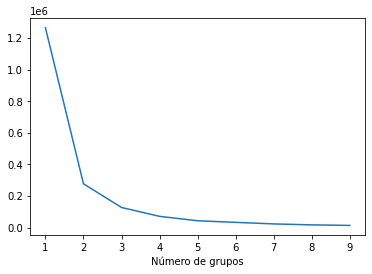

In [365]:
# Se lleva a cabo un gráfico del codo para obtener el número óptimo de grupos:
sse={}
tx_recencia = data_cliente[["Recencia"]]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recencia)
    tx_recencia["Grupos"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Número de grupos")
plt.show()

De acuerdo al gráfico del codo la selección de grupos puede estar entre 3 y 4, en este proyecto se seleccionarán 4 grupos.

In [366]:
# Se desarrolla el modelo K-Means para asignar los clientes a cada cluster de recencia:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_cliente[["Recencia"]])
data_cliente["Grupo_Recencia"] = kmeans.predict(data_cliente[["Recencia"]])

In [367]:
# Se observa el encabezado del dataframe con la columna "Cluster_Recencia":
data_cliente.head()

,ID_Cliente,Recencia,Grupo_Recencia
0,14620.0,12,2
1,14740.0,4,2
2,13880.0,25,0
3,16462.0,91,1
4,17068.0,11,2


Se han calculado los grupos de recencia y se han asignado los clientes a cada uno.

In [368]:
# Se analizan los valores de recencia para cada uno de los grupos:
data_cliente.groupby("Grupo_Recencia")["Recencia"].describe()

,count,mean,std,min,25%,50%,75%,max
Grupo_Recencia,,,,,,,,
0,444.0,24.373874,4.959870,17.0,20.0,23.0,27.0,35.0
1,349.0,76.885387,8.373023,64.0,70.0,76.0,84.0,91.0
2,608.0,8.312500,4.404323,0.0,5.0,8.0,12.0,16.0
3,439.0,50.020501,7.377743,39.0,43.0,49.0,56.0,63.0


Se puede observar que los grupos no están ordenados (el grupo 0 es el que tendría que tener el valor promedio de inactividad más alto y el grupo 3 el más bajo, dado que los mejores clientes son los más activos). 

A continuación se calcula una función para ordenar los grupos.

In [369]:
# Se define una función para ordenar los grupos:
def grupo_ordenado(nombre_grupo, metrica,df,ascending):
    nombre_grupo_nuevo = "new_" + nombre_grupo
    data = df.groupby(nombre_grupo)[metrica].mean().reset_index()
    data = data.sort_values(by=metrica,ascending=ascending).reset_index(drop=True)
    data["indice"] = data.index
    df_final = pd.merge(df,data[[nombre_grupo,"indice"]], on=nombre_grupo)
    df_final = df_final.drop([nombre_grupo],axis=1)
    df_final = df_final.rename(columns={"indice":nombre_grupo})
    return df_final

data_cliente = grupo_ordenado("Grupo_Recencia", "Recencia", data_cliente, False)

In [370]:
# Se analizan los valores de recencia con los grupos ordenados:
data_cliente.groupby("Grupo_Recencia")["Recencia"].describe()


,count,mean,std,min,25%,50%,75%,max
Grupo_Recencia,,,,,,,,
0,349.0,76.885387,8.373023,64.0,70.0,76.0,84.0,91.0
1,439.0,50.020501,7.377743,39.0,43.0,49.0,56.0,63.0
2,444.0,24.373874,4.959870,17.0,20.0,23.0,27.0,35.0
3,608.0,8.312500,4.404323,0.0,5.0,8.0,12.0,16.0


El grupo 3 quedó conformado con los clientes con la menor inactividad  y el grupo 0 con clientes con la mayor cantidad de días promedio de días inactivos desde la última compra.

**8) Cálculo de la Frecuencia**

Para crear grupos en base a la frecuencia de compras, es necesario determinar el número total de compras de cada cliente en el periodo bajo análisis.

In [371]:
# Se crea un dataframe con datos de la frecuencia de compras en los primer tres meses:
data1 = data_3m.groupby("ID_Cliente").F_Factura.count().reset_index()
data1.columns = ["ID_Cliente","Frecuencia"]
# Se une el dataframe de frecuencia con el dataframe de recencia
data_cliente = pd.merge(data_cliente, data1, on="ID_Cliente")

In [372]:
# Se obsvera el dataframe con la columna "Frecuencia":
data_cliente.head()

,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia
0,14620.0,12,3,30
1,14740.0,4,3,89
2,17068.0,11,3,76
3,12971.0,4,3,73
4,15194.0,6,3,64


Se observa la frecuencia de compra de cada cliente.

In [373]:
# Se observan las principales estadísticas descriptivas de la frecuencia de compra:
data_cliente.Frecuencia.describe().round()


count    1840.0
mean       39.0
std        60.0
min         1.0
25%        12.0
50%        23.0
75%        47.0
max      1346.0
Name: Frecuencia, dtype: float64

El promedio de compras por cliente es 39 mientras que la mediana de compras es de 23 unidades.

In [374]:
# Se realiza un histograma para analizar la distribución de la frecuencia de compra de los clientes:
plot_data = [
    go.Histogram(
        x=data_cliente.query("Frecuencia < 1000")["Frecuencia"])] # Se incluyen valores de frecuencia menores a 1000 para facilitar la visualización
plot_layout = go.Layout(
        title="Frecuencia"
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


Las cantidades de compras comprendidas entre 10-19 unidades son las de mayor frecuencia.

In [375]:
# Se desarrolla el modelo K-Means para asignar los clientes a cada grupo de frecuencia:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_cliente[["Frecuencia"]])
data_cliente["Grupo_Frecuencia"] = kmeans.predict(data_cliente[["Frecuencia"]])

In [376]:
# Se observa el encabezado del dataframe con la columna "Cluster_Frecuencia":
data_cliente.head()

,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia
0,14620.0,12,3,30,0
1,14740.0,4,3,89,1
2,17068.0,11,3,76,1
3,12971.0,4,3,73,1
4,15194.0,6,3,64,0


Se han calculado los grupos de frecuencia y se ha asignado a cada cliente a cada uno de éstos.

In [377]:
# Se observan los distintos grupos de frecuencia ordenados
# Se coloca ascending True para que ordene los valores de la media de menor a mayor:
data_cliente = grupo_ordenado("Grupo_Frecuencia", "Frecuencia", data_cliente,True) 
data_cliente.groupby("Grupo_Frecuencia")["Frecuencia"].describe()

,count,mean,std,min,25%,50%,75%,max
Grupo_Frecuencia,,,,,,,,
0,1604.0,24.008105,17.497685,1.0,10.00,20.0,35.0,69.0
1,224.0,114.642857,43.126232,70.0,81.75,104.0,128.0,280.0
2,11.0,490.000000,123.499798,327.0,420.00,448.0,552.0,724.0
3,1.0,1346.000000,NaN,1346.0,1346.00,1346.0,1346.0,1346.0


El grupo 3 es el que tiene a los clientes con la mayor frecuencia promedio de compras y el grupo 0 a los de menor frecuencia.

**9) Cálculo del Ingreso**

A continuación se agruparán los clientes en base a los ingresos que generaron a la empresa, siguiendo los mismos pasos realizados para los grupos de recencia y frecuencia.

In [378]:
# Se calcula el ingreso que genera cada cliente en el dataframe "data_3m":
data_3m["Ingreso"] = data_3m["Precio"] * data_3m["Cantidad"]
tx_ingreso = data_3m.groupby("ID_Cliente").Ingreso.sum().reset_index()
tx_ingreso.head()

,ID_Cliente,Ingreso
0,12747.0,1082.09
1,12748.0,4276.60
2,12749.0,782.10
3,12821.0,92.72
4,12823.0,459.00


In [379]:
# Se unen los dataframes:
data_cliente = pd.merge(data_cliente, tx_ingreso, on="ID_Cliente")
# Se obsvera el dataframe con la columna "Ingreso":
data_cliente.head(2)


,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia,Ingreso
0,14620.0,12,3,30,0,393.28
1,15194.0,6,3,64,0,1439.02


Se observa el ingreso generado por cada cliente.

In [380]:
# Se observan las principales estadísticas descriptivas del ingreso:
data_cliente.Ingreso.describe().round(0)

count     1840.0
mean       737.0
std       1639.0
min      -1462.0
25%        208.0
50%        368.0
75%        748.0
max      35085.0
Name: Ingreso, dtype: float64

El ingreso promedio generado por cliente es de 737 usd mientras que la mediana es de 368 usd.

In [381]:
# Se realiza un histograma para analizar la distribución del Ingreso por cliente:
plot_data = [
    go.Histogram(
        x=data_cliente.query("Ingreso < 10000")["Ingreso"])]  # Se incluyen valores de ingresos menores a 1000 para facilitar la visualización
plot_layout = go.Layout(
        title="Ingreso"
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Los ingresos entre 100 y 200 usd son los de mayor frecuencia., a su vez se observa que hay algunos clientes que no generaron ingresos y otros que generaron ingresos negativos.

In [382]:
# Se desarrolla el modelo K-Means para asignar los clientes a cada grupo de ingreso:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_cliente[["Ingreso"]])
data_cliente["Grupo_Ingreso"] = kmeans.predict(data_cliente[["Ingreso"]])

In [383]:
# Se observa el dataframe con la columna "Cluster_Ingreso":
data_cliente.head()

,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia,Ingreso,Grupo_Ingreso
0,14620.0,12,3,30,0,393.28,0
1,15194.0,6,3,64,0,1439.02,0
2,18044.0,5,3,57,0,808.96,0
3,18075.0,12,3,35,0,638.12,0
4,15241.0,0,3,64,0,947.55,0


Se han calculado los grupos por ingreso y se han asignados a los clientes a cada uno.

In [384]:
# Se observan los distintos grupos de ingreso ordenados
# Se coloca ascending True para que ordene los valores de la media de menor a mayor:
data_cliente = grupo_ordenado("Grupo_Ingreso", "Ingreso", data_cliente,True)
data_cliente.groupby("Grupo_Ingreso")["Ingreso"].describe()

,count,mean,std,min,25%,50%,75%,max
Grupo_Ingreso,,,,,,,,
0,1755.0,502.271151,442.287455,-1462.50,202.4500,348.260,664.0100,2110.62
1,73.0,3731.028644,1538.265907,2131.72,2655.5400,3134.130,4184.4300,7969.99
2,10.0,14076.693000,2852.812849,10348.13,11252.4300,15124.345,16052.6900,17700.64
3,2.0,30599.645000,6343.928696,26113.81,28356.7275,30599.645,32842.5625,35085.48


Los clientes del cluster 3 son los que en promedio generan mayor ingreso a la empresa, y está compuesto solo por dos integrantes, mientras que el grupo 0 es el de aquellos clientes que menos ingresos generan y el que con más integrantes cuenta.

**10) Definición de los Segmentos**

Hasta ahora se han creado los grupos de clientes tanto para la resencia, frecuencia como para los ingresos. A continuación se va definir un puntaje para cada uno de los clientes en base a los tres grupos a los cuales pertenece, para luego finalmente asignar a cada cliente un valor (que puede ser bajo, medio o alto).

In [385]:
# Se calcula el puntaje  de cada cliente en base a su recencia, frecuencia e ingreso generado:
data_cliente["Puntaje"] = data_cliente["Grupo_Recencia"] + data_cliente["Grupo_Frecuencia"] + data_cliente["Grupo_Ingreso"]
# Se observa el dataframe con la columna "Puntaje":
data_cliente.head()


,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia,Ingreso,Grupo_Ingreso,Puntaje
0,14620.0,12,3,30,0,393.28,0,3
1,15194.0,6,3,64,0,1439.02,0,3
2,18044.0,5,3,57,0,808.96,0,3
3,18075.0,12,3,35,0,638.12,0,3
4,15241.0,0,3,64,0,947.55,0,3


In [386]:
# Se agrupa por la columna puntaje y se calcula la media de cada una de las métricas:
data_cliente.groupby("Puntaje")["Recencia", "Frecuencia", "Ingreso"].mean()


,Recencia,Frecuencia,Ingreso
Puntaje,,,
0,77.014925,18.244776,294.882179
1,50.918854,24.202864,365.507995
2,26.559524,30.683333,500.087738
3,10.250509,36.197556,630.549470
4,8.132812,102.585938,1974.915008
5,6.400000,137.066667,4248.259000
6,7.357143,318.357143,12154.152143
7,3.000000,770.666667,11284.046667


A continuación se categorizan los puntajes obtenidos en tres segmentos/niveles:

* De 0 a 2: valor bajo

* De 3 a 4: valor medio

* 5 o más: valor alto

In [387]:
# Se calculan los tres niveles de acuerdo al puntaje:
data_cliente["Segmento"] = "Valor-Bajo"
data_cliente.loc[data_cliente["Puntaje"]>2,"Segmento"] = "Valor-Medio"
data_cliente.loc[data_cliente["Puntaje"]>4,"Segmento"] = "Valor-Alto"
# Se observa como queda el dataframe con la columna "Segmento":
data_cliente.head()

,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia,Ingreso,Grupo_Ingreso,Puntaje,Segmento
0,14620.0,12,3,30,0,393.28,0,3,Valor-Medio
1,15194.0,6,3,64,0,1439.02,0,3,Valor-Medio
2,18044.0,5,3,57,0,808.96,0,3,Valor-Medio
3,18075.0,12,3,35,0,638.12,0,3,Valor-Medio
4,15241.0,0,3,64,0,947.55,0,3,Valor-Medio


In [388]:
# Se agrupa por la columna segmento y se calcula la media de cada una de las métricas:
data_cliente.groupby("Segmento")["Recencia","Frecuencia", "Ingreso"].mean().sort_values(by="Recencia", ascending=True)

,Recencia,Frecuencia,Ingreso
Segmento,,,
Valor-Alto,6.468085,231.510638,7052.298723
Valor-Medio,9.812601,49.925687,908.544283
Valor-Bajo,49.650767,24.821124,393.501048


La agrupación muestra claramente que los clientes pertenecientes al segmento "Valor-Alto" cuentan en promedio con el valor más bajo de recencia, más alto de frecuencia y los ingresos más altos., los clientes pertenecientes al segmento "Valor-Medio" cuentan en promedio con el segundo valor más bajo de recencia, el segundo valor más alto de frecuencia y el segundo valor ingresos más altos., por último los clientes del segmento "Valor-Bajo" cuentan con el valor de recencia màs alto, y los niveles de frecuencia e ingreso màs bajos.

Por último se observa como se distribuyen los segmentos en diagramas de relación de a dos variables.

In [389]:
# Se grafica la relación entre Frecuencia e Ingreso, para cada uno de los tres segmentos:

tx_graph = data_cliente.query("Ingreso < 50000 and Frecuencia < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Bajo'")["Frecuencia"],
        y=tx_graph.query("Segmento == 'Valor-Bajo'")["Ingreso"],
        mode="markers",
        name="Bajo",
        marker= dict(size= 7,
            line= dict(width=1),
            color= "blue",
            opacity= 0.8)),
        go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Medio'")["Frecuencia"],
        y=tx_graph.query("Segmento == 'Valor-Medio'")["Ingreso"],
        mode="markers",
        name="Medio",
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5 )),
        go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Alto'")["Frecuencia"],
        y=tx_graph.query("Segmento == 'Valor-Alto'")["Ingreso"],
        mode='markers',
        name="Alto",
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9 )),]

plot_layout = go.Layout(
        yaxis= {"title": "Ingreso"},
        xaxis= {"title": "Frecuencia"},
        title="Segmentos" )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Se corrobora mediante el gráfico que los clientes con valor bajo tienen en promedio baja frecuencia y bajo ingreso.

In [390]:
# Se grafica la relación entre Recencia e Ingreso, para cada uno de los tres segmentos:

tx_graph = data_cliente.query("Ingreso < 50000 and Recencia < 1000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Bajo'")["Recencia"],
        y=tx_graph.query("Segmento == 'Valor-Bajo'")["Ingreso"],
        mode="markers",
        name="Bajo",
        marker= dict(size= 7,
            line= dict(width=1),
            color= "blue",
            opacity= 0.8)),
        go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Medio'")["Recencia"],
        y=tx_graph.query("Segmento == 'Valor-Medio'")["Ingreso"],
        mode="markers",
        name="Medio",
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5 )),
        go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Alto'")["Recencia"],
        y=tx_graph.query("Segmento == 'Valor-Alto'")["Ingreso"],
        mode='markers',
        name="Alto",
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9 )),]

plot_layout = go.Layout(
        yaxis= {"title": "Ingreso"},
        xaxis= {"title": "Recencia"},
        title="Segmentos" )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


Se corrobora mediante el gráfico que los clientes con valor alto tienen baja recencia y alto ingreso.

In [391]:
# Se grafica la relación entre Recencia Y Frecuencia, para cada uno de los tres segmentos:

tx_graph = data_cliente.query("Frecuencia < 2000 and Recencia < 1000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Bajo'")["Recencia"],
        y=tx_graph.query("Segmento == 'Valor-Bajo'")["Frecuencia"],
        mode="markers",
        name="Bajo",
        marker= dict(size= 7,
            line= dict(width=1),
            color= "blue",
            opacity= 0.8)),
        go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Medio'")["Recencia"],
        y=tx_graph.query("Segmento == 'Valor-Medio'")["Frecuencia"],
        mode="markers",
        name="Medio",
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5 )),
        go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Alto'")["Recencia"],
        y=tx_graph.query("Segmento == 'Valor-Alto'")["Frecuencia"],
        mode='markers',
        name="Alto",
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9 )),]

plot_layout = go.Layout(
        yaxis= {"title": "Frecuencia"},
        xaxis= {"title": "Recencia"},
        title="Segmentos" )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Se corrobora mediante el gráfico que los clientes con valor intermedio tienen valores intermedios de frecuencia y valores intermedios de recencia.

Una vez definidos los segmentos de valor de los clientes para los primeros tres meses, a continuación se definirán tres grupos de CLV (valor de vida de los clientes) en base al dataframe de 6 meses.
 En la base de datos no hay ninguna columna con datos de costos, por lo que el Ingreso se convierte directamente en el CLV.

**11) Cálculo del CLV (Valor de vida de los clientes)** 

In [392]:
# Se observa el encabezado del dataframe data_cliente:
data_cliente.head()


,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia,Ingreso,Grupo_Ingreso,Puntaje,Segmento
0,14620.0,12,3,30,0,393.28,0,3,Valor-Medio
1,15194.0,6,3,64,0,1439.02,0,3,Valor-Medio
2,18044.0,5,3,57,0,808.96,0,3,Valor-Medio
3,18075.0,12,3,35,0,638.12,0,3,Valor-Medio
4,15241.0,0,3,64,0,947.55,0,3,Valor-Medio


In [393]:
# Se observa el encabezado del dataframe de seis meses creado en el comienzo de este proyecto:
data_6m.head()


,N_Factura,N_Stock,Descripcion,Cantidad,F_Factura,Precio,ID_Cliente,Pais
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom


In [394]:
# Se crea la columna "Ingreso" para este dataframe:
data_6m["Ingreso_6m"] = data_6m["Precio"] * data_6m["Cantidad"]
data_6m.head()



,N_Factura,N_Stock,Descripcion,Cantidad,F_Factura,Precio,ID_Cliente,Pais,Ingreso_6m
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom,22.50
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom,16.95
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom,66.40
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom,32.70
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom,51.00


In [395]:
# Se agrupa por "ID_Cliente" y se calcula el ingreso total de cada cliente_
data_user_6m = data_6m.groupby("ID_Cliente")["Ingreso_6m"].sum().reset_index()
data_user_6m

,ID_Cliente,Ingreso_6m
0,12747.0,1666.11
1,12748.0,18196.70
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98
...,...,...
3162,18278.0,173.90
3163,18281.0,80.82
3164,18282.0,98.76
3165,18283.0,1322.01


Se puede ver el ingreso total generado por cada cliente en los 6 meses de análisis.

In [396]:
# Se grafica la distribución del "CLV_6m":
plot_data = [
    go.Histogram(
        x=data_user_6m.query("Ingreso_6m < 10000")["Ingreso_6m"])]

plot_layout = go.Layout(title="CLV_6m" )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

El histograma muestra claramente que existen clientes con CLV negativo. También tenemos algunos valores atípicos. Filtrar los valores atípicos tiene sentido para tener un modelo de aprendizaje automático adecuado. 


El siguiente paso es fusionar el dataframe de 3 meses con el de 6 meses para ver las correlaciones entre CLV y el resto de características.

In [397]:
# Se fusionan los dos dataframes:
data_merge = pd.merge(data_cliente, data_user_6m, on="ID_Cliente", how="left")
# Se reemplazan con cero los datos faltantes (Nan):
data_merge = data_merge.fillna(0)
# Se observa el encabezado del dataframe resultante:
data_merge.head()

,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia,Ingreso,Grupo_Ingreso,Puntaje,Segmento,Ingreso_6m
0,14620.0,12,3,30,0,393.28,0,3,Valor-Medio,0.00
1,15194.0,6,3,64,0,1439.02,0,3,Valor-Medio,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Valor-Medio,991.54
3,18075.0,12,3,35,0,638.12,0,3,Valor-Medio,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Valor-Medio,791.04


In [398]:
# Se agrupa por segmento y se calcula la media de "Ingreso_6m":
data_merge.groupby("Segmento")["Ingreso_6m"].mean().sort_values(ascending=True)


Segmento
Valor-Bajo       700.320392
Valor-Medio     1715.260922
Valor-Alto     17630.570851
Name: Ingreso_6m, dtype: float64

Los clientes que pertenecen al segmento Valor-Bajo generan en promedio 683 usd. 

In [399]:
# Se grafica la relación entre puntaje e ingreso_6m:
tx_graph = data_merge.query("Ingreso_6m < 10000")  

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Bajo'")["Puntaje"],
        y=tx_graph.query("Segmento == 'Valor-Bajo'")["Ingreso_6m"],
        mode="markers",
        name="Bajo",
        marker= dict(size= 7,
            line= dict(width=1),
            color= "blue",
            opacity= 0.8)),
        go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Medio'")["Puntaje"],
        y=tx_graph.query("Segmento == 'Valor-Medio'")["Ingreso_6m"],
        mode="markers",
        name="Medio",
        marker= dict(size= 9,
            line= dict(width=1),
            color= "green",
            opacity= 0.5 )),
        go.Scatter(
        x=tx_graph.query("Segmento == 'Valor-Alto'")["Puntaje"],
        y=tx_graph.query("Segmento == 'Valor-Alto'")["Ingreso_6m"],
        mode="markers",
        name="Alto",
        marker= dict(size= 11,
            line= dict(width=1),
            color= "red",
            opacity= 0.9)),]

plot_layout = go.Layout(
        yaxis= {"title": "CLV_6m"},
        xaxis= {"title": "Puntaje"},
        title="CLV")
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Existe una correlación positiva bastante visible, un puntaje alto significa un CLV_6m alto.
Es importante tener en cuenta que el valor de vida de los clientes es en principio un problema de regresión (por ejemplo, predecir el valor en dólares del CLV), sin embargo en este proyecto se pretende clasificar segmentos de CLV dado que de esta manera será más fácil el proceso de comunicación de resultados. Por lo cual antes de pasar a los modelos de clasificación (aprendizaje supervisado) se realizará una agrupación con K-means (aprendizaje no supervisado) para identificar tres segmentos de valor de los clientes en base al CLV:

* CLV Bajo

* CLV Medio

* CLV Alto

In [400]:
# Primero se quitan los outliers de la columna "Ingreso_6m":
data_merge = data_merge[data_merge["Ingreso_6m"]<data_merge["Ingreso_6m"].quantile(0.99)]




In [401]:
# Se crean tres grupos:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_merge[["Ingreso_6m"]])
data_merge["CLV_Grupo"] = kmeans.predict(data_merge[["Ingreso_6m"]])



In [402]:
# Se ordena el número de grupos basado en LTV:
data_merge = grupo_ordenado("CLV_Grupo", "Ingreso_6m",data_merge,True)


In [403]:
# Se crea un nuevo dataframe data_cluster como copia de data_merge:
data_grupo = data_merge.copy()
# Se observa el encabezado del dataframe creado:
data_grupo.head()



,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia,Ingreso,Grupo_Ingreso,Puntaje,Segmento,Ingreso_6m,CLV_Grupo
0,14620.0,12,3,30,0,393.28,0,3,Valor-Medio,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Valor-Medio,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Valor-Medio,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Valor-Medio,791.04,0
4,15660.0,4,3,34,0,484.62,0,3,Valor-Medio,858.09,0


In [404]:
# Se observa los distintos grupos de CLTV ordenados:
data_grupo.groupby("CLV_Grupo")["Ingreso_6m"].describe()

,count,mean,std,min,25%,50%,75%,max
CLV_Grupo,,,,,,,,
0,1395.0,394.904775,418.582038,-609.40,0.0000,293.170,680.4200,1425.74
1,370.0,2487.413838,934.635654,1445.93,1732.1750,2159.605,3034.0575,5280.79
2,56.0,8211.598750,2981.433603,5396.44,6140.7075,6986.545,9607.3225,16756.31


Finalmente se puede observar como quedan conformados los grupos en base al promedio de CLV. Es evidente que no se quieren perder los clientes pertenecientes al grupo 2.

**12) Pre-procesamiento de datos**

Quedan algunos pasos más antes de entrenar el modelo de clasificación: 

Antes de llevar a cabo los modelos de clasificación es necesario realizar una serie de transformaciones (transformación de variables cualitativas en cuantitativas, escalado de datos, etc.) que forman parte de la etapa de preprocesamiento de datos, que se detalla a continuación. 

**a) Transformación de variables cualitativas en variables dummies**

In [405]:
# Se observa en detalle el tipo de columnas del dataframe:
data_grupo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1821 entries, 0 to 1820
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_Cliente        1821 non-null   float64
 1   Recencia          1821 non-null   int64  
 2   Grupo_Recencia    1821 non-null   int64  
 3   Frecuencia        1821 non-null   int64  
 4   Grupo_Frecuencia  1821 non-null   int64  
 5   Ingreso           1821 non-null   float64
 6   Grupo_Ingreso     1821 non-null   int64  
 7   Puntaje           1821 non-null   int64  
 8   Segmento          1821 non-null   object 
 9   Ingreso_6m        1821 non-null   float64
 10  CLV_Grupo         1821 non-null   int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 170.7+ KB


La columna "Segmento" es la única columna cualitatitiva del dataframe.

In [406]:
# Se convierte la columna cualitativa "Segmento" en columna cuantitativa a través del método de pandas .get_dummies()
data_class = pd.get_dummies(data_grupo)
data_class.head()


,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia,Ingreso,Grupo_Ingreso,Puntaje,Ingreso_6m,CLV_Grupo,Segmento_Valor-Alto,Segmento_Valor-Bajo,Segmento_Valor-Medio
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,991.54,0,0,0,1
2,18075.0,12,3,35,0,638.12,0,3,1322.75,0,0,0,1
3,15241.0,0,3,64,0,947.55,0,3,791.04,0,0,0,1
4,15660.0,4,3,34,0,484.62,0,3,858.09,0,0,0,1


La columna "Segmento" original desaparece y se convierte en 3 columnas, en la que el valor 1 significa que la observación pertenece a dicha columna, y cero en caso contrario.

**b) Análisis de correlaciones entre las variables:**

Se realiza un análisis de la correlación de las variables con el fin de hacer una selección de características.

In [407]:
# Se observan las correlaciones entre las columnas:
corr_matrix = data_class.corr()
corr_matrix

,ID_Cliente,Recencia,Grupo_Recencia,Frecuencia,Grupo_Frecuencia,Ingreso,Grupo_Ingreso,Puntaje,Ingreso_6m,CLV_Grupo,Segmento_Valor-Alto,Segmento_Valor-Bajo,Segmento_Valor-Medio
ID_Cliente,1.000000,-0.002528,0.006726,-0.043206,-0.003763,-0.060141,-0.047238,-0.002568,-0.039394,-0.027707,-0.056361,0.005218,0.011095
Recencia,-0.002528,1.000000,-0.965208,-0.258467,-0.219647,-0.310746,-0.179093,-0.914367,-0.251255,-0.239670,-0.156301,0.731302,-0.695528
Grupo_Recencia,0.006726,-0.965208,1.000000,0.253213,0.210686,0.313185,0.176243,0.941395,0.250802,0.238673,0.163127,-0.807441,0.770688
Frecuencia,-0.043206,-0.258467,0.253213,1.000000,0.788143,0.495718,0.345826,0.480448,0.377413,0.363728,0.472283,-0.336724,0.203896
Grupo_Frecuencia,-0.003763,-0.219647,0.210686,0.788143,1.000000,0.456113,0.314361,0.495373,0.376595,0.365490,0.422974,-0.352889,0.234607
Ingreso,-0.060141,-0.310746,0.313185,0.495718,0.456113,1.000000,0.785019,0.511903,0.739007,0.601148,0.575432,-0.364409,0.201965
Grupo_Ingreso,-0.047238,-0.179093,0.176243,0.345826,0.314361,0.785019,1.000000,0.390133,0.621158,0.468671,0.686128,-0.243081,0.046861
Puntaje,-0.002568,-0.914367,0.941395,0.480448,0.495373,0.511903,0.390133,1.000000,0.411785,0.374736,0.358978,-0.824351,0.730896
Ingreso_6m,-0.039394,-0.251255,0.250802,0.377413,0.376595,0.739007,0.621158,0.411785,1.000000,0.845968,0.474895,-0.284609,0.150333
CLV_Grupo,-0.027707,-0.239670,0.238673,0.363728,0.365490,0.601148,0.468671,0.374736,0.845968,1.000000,0.353547,-0.266947,0.167710


In [408]:
# Se analiza en detalle la correlación de "CLV_Cluster" con el resto de variables:
corr_matrix["CLV_Grupo"].sort_values(ascending=False)



CLV_Grupo               1.000000
Ingreso_6m              0.845968
Ingreso                 0.601148
Grupo_Ingreso           0.468671
Puntaje                 0.374736
Grupo_Frecuencia        0.365490
Frecuencia              0.363728
Segmento_Valor-Alto     0.353547
Grupo_Recencia          0.238673
Segmento_Valor-Medio    0.167710
ID_Cliente             -0.027707
Recencia               -0.239670
Segmento_Valor-Bajo    -0.266947
Name: CLV_Grupo, dtype: float64

La columna "CLV_grupo" es la variable target y no se incluirá en los modelos a la columna "Ingreso_6m" por estar altamente correlacionada con ésta. El resto de características serán utilizadas como variables predictoras.

**c) Separación de datos en las variables X e y**

Se dividen los datos en dos variables, X e y, las cuales serán utilizadas en los algoritmos de clasificación. 

In [409]:
# Se crean las variables X e y:
X = data_class.drop(["CLV_Grupo","Ingreso_6m"],axis=1)
y = data_class["CLV_Grupo"]



**d) Separación de los datos de entrenamiento y testeo**

Se lleva a cabo una separación de los datos, dividiéndolos en 80% de entrenamiento y 20% de testeo, con el fin de reservar una parte de los datos los cuales serán desconocidos para los modelos, y evitar un sobreajuste de los modelos.

In [410]:
# Se realiza la división entre datos de entrenamiento y datos de testeo:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

**e) Escalado de los datos**

El escalado de los datos es importante para unificar las escalas de las característivas, dado que si algunas de éstas cuentan con escalas mucho más grandes que otras pueden influir desproporcionadamente en los modelos. En este caso se utiliza la estandarización a través del método StandardScaler(), que reajusta los datos para que tengan una media de 0 y una desviación estándar de 1.

In [411]:
# Se realiza la Estandarización de los datos de X:
# La división de datos se realiza antes de la estandarización para evitar la fuga de datos
scaler = StandardScaler() # se crea la instancia de un objeto StandarScaler
X_train= scaler.fit_transform(X_train) # se llama al método fit_transform pasandole como argumento las características de entrenamiento
X_test= scaler.transform(X_test) # se llama al método transform pasandole como argumento las características de testeo

**13) Desarrollo de Modelos de Clasificación**

A continuación se llevarán a cabo una serie de modelos de machine learning con el fin de realizar una clasificación multiclase de los grupos de CLV. En algunos de ellos se incluirá validación cruzada para obtener los mejores hiperparámetros, y también se desarrollarán modelos de ensamble.


**a) Regresión Logística**

In [412]:
# Se lleva a cabo un modelo de Regresión Logística:
# Se instancia el clasificador:
l_g = LogisticRegression()
# Se entrena el calsificador:
l_g.fit(X_train, y_train)
# Se realiza predicción en los datos de testeo:
y_pred = l_g.predict(X_test)

In [413]:
# Se calcula la exactitud del clasificador tanto en el conjunto de entrenamiento como de testeo:
print("Exactitud del clasificador en el conjunto de entrenamiento: {:.2f}"
       .format(l_g.score(X_train, y_train)))
print("Exactitud del clasificador en el conjunto de testeo: {:.2f}"
       .format(l_g.score(X_test, y_test)))

Exactitud del clasificador en el conjunto de entrenamiento: 0.81
Exactitud del clasificador en el conjunto de testeo: 0.82


El clasificador de regresión logística tiene un accuracy (exactitud) del 81% en el conjunto de datos de entrenamiento y del 82% en el conjunto de datos de testeo. Esta última es la métrica mas importante ya que se calcula sobre un conjunto de datos desconocido.

In [462]:
# Se observa la composición porcentual de cada uno de los grupos de CLV anteriormente confeccionados:
porcentaje = data_class.groupby("CLV_Grupo").ID_Cliente.count()/data_class.ID_Cliente.count()
porcentaje = porcentaje * 100
porcentaje.round()


CLV_Grupo
0    77.0
1    20.0
2     3.0
Name: ID_Cliente, dtype: float64

La exactitud en el conjunto de testeo es del 82%. En principio parece un buen porcentaje, pero es importante compararlo con un punto de referencia. El grupo más grande es el cero, que constituye el 77 % de la base total. Si se supone ciegamente que todos los clientes pertenecen al grupo 0, entonces la exactitud sería del 77 %.
El 82% frente al porcentaje anterior nos dice que el modelo de aprendizaje automático es útil, sin embargo se pueden aplicar mejoras para lograr un mejor rendimiento. 

In [415]:
# Se calcula la Matriz de Confusión:
cm = confusion_matrix(y_test, y_pred) # y_test(etiquetas reales), y_pred(etiquetas predichas)
cm

array([[262,   9,   1],
       [ 48,  27,   2],
       [  1,   6,   9]])

En el caso de un problema de clasificación multiclase, como este, no se puede hablar de "positivos" y "negativos", dado que hay más de dos categorías, por lo que simplemente se hablará de "aciertos" y "desaciertos", los primeros estarán en la diagonal principal de la matriz mientras que por fuera de ella estarán las clasificaciones erróneas. 
 Se observa que 262 clientes fueron clasificados correctamente en el grupo 0 (CLV bajo), 27 en el grupo 1 (CLV intermedio), y 9 en el grupo 2 (CLV alto), es decir 298 clasificaciones correctas en total, lo que corrobora el 82% de exactitud.

In [416]:
# Se calculan las métricas de rendimiento del modelo:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.96      0.90       272
           1       0.64      0.35      0.45        77
           2       0.75      0.56      0.64        16

    accuracy                           0.82       365
   macro avg       0.75      0.63      0.67       365
weighted avg       0.80      0.82      0.79       365



La precisión y la sensibilidad (recall) son aceptables para la clase 0. La precisión establece que de 100 clientes clasificados en la clase 0, 84 fueron clasificados correctamente, es decir, 14 clientes fueron falsos positivos., y el modelo identifica con éxito al 96% de los clientes reales de la clase 0 (hay un 4% de falsos negativos, es decir, clientes que si pertenecian a la clase 0 pero fueron clasificados en otras clases). Se observa que es necesario mejorar el modelo para las otras clases (1 y 2)., por ejemplo el modelo solo detecta el 35% de los clientes reales de la clase 1 (CLV medio).

**b) Modelo Árboles de Decisión Clasificación**

In [417]:
# Se lleva a cabo un modelo de Árbol de Decisión con ajuste de hiperparámetros a través de la validación cruzada Grid Search:
# Se instancia el modelo de Árbol de Decisión:
decision_tree = DecisionTreeClassifier(random_state=10) 
# Se crea un diccionario con alternativas para los hiperparámetros:
parameters = {
             "max_depth": [2, 3, 4, 6, 8],
             "min_samples_leaf": [0.12, 0.14, 0.16, 0.18, 0.20] # porcentaje de datos de entrenamiento en cada hoja
            }
# Se crea una instancia de validación cruzada Grid Search para diferentes valores de los hiperparámetros:
cv = GridSearchCV(estimator=decision_tree, 
                  param_grid=parameters, 
                  scoring="accuracy",  
                  verbose = 1, # Muestra el resultado en pantalla
                  n_jobs = -1) # Ejecución en paralelo
# Se ajusta el modelo con los datos de entrenamiento:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 6, 8],
                         'min_samples_leaf': [0.12, 0.14, 0.16, 0.18, 0.2]},
             scoring='accuracy', verbose=1)

In [418]:
# Se establece el mejor modelo:
best_model = cv.best_estimator_
best_model

DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.12, random_state=10)

In [419]:
# Se evalúa la exactitud (accuracy) en el set de testeo:
test_acc = best_model.score(X_test, y_test)
test_acc

0.7835616438356164

In [420]:
# Se utiliza el método predict para realizar una predicción con los datos de testeo, con el mejor modelo
# y_pred = cv.predict(X_test_scaled)
y_pred = cv.best_estimator_.predict(X_test)

In [421]:
# Se calcula la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred) # y_test(etiquetas reales), y_pred(etiquetas predichas)
cm

array([[261,  11,   0],
       [ 52,  25,   0],
       [  1,  15,   0]])

Con este algoritmo 261 clientes fueron clasificados correctamente en el grupo 0 (CLV bajo), 25 en el grupo 1 (CLV intermedio), y ninguno en el grupo 2 (CLV alto), es decir 286 clasificaciones correctas en total, lo que corrobora el 78% de exactitud.

In [422]:
# Se calculan las métricas de rendimiento del modelo:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.96      0.89       272
           1       0.49      0.32      0.39        77
           2       0.00      0.00      0.00        16

    accuracy                           0.78       365
   macro avg       0.44      0.43      0.43       365
weighted avg       0.72      0.78      0.75       365



La precisión y la sensibilidad (recall) son aceptables para la clase 0. La precisión establece que de 100 clientes clasificados en la clase 0, 83 fueron clasificados correctamente, es decir, 17 clientes fueron falsos positivos., y el modelo identifica con éxito al 96% de los clientes reales de la clase 0 (hay un 4% de falsos negativos, es decir, clientes que si pertenecian a la clase 0 pero fueron clasificados en otras clases). Se observa que es necesario mejorar el modelo para las otras clases, sobretodo la clase 2, ya que no detecta ninguno de los clientes reales de esta clase.

Los métodos basados ​​en árboles, permiten calcular la importancia de las características, en base a puntuaciones que representan cuánto contribuye cada característica a la clasificación de clases. Esto permite saber que características son importantes para el modelo y cuales es conveniente eliminar. 

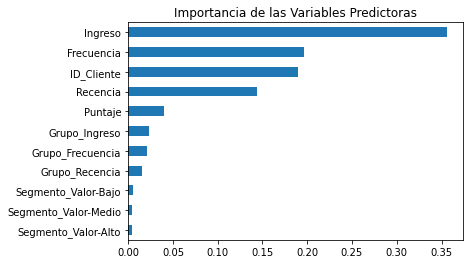

In [464]:
# Se evalúa la importancia de las características midiendo cuanto usan los nodos del árbol una variable en particular para reducir la "impureza"
# La importancia de una variable se expresa como un porcentaje que indica el peso de la misma en el entrenamiento y en la predicción:
# Se crea una serie con las características y su nivel de importancia:
X_series = pd.DataFrame(X)
importances = pd.Series(best_model.feature_importances_, index=X_series.columns)
# Se ordena la serie:
sorted_importances = importances.sort_values()
# Se realiza un gráfico de barras horizontal:
sorted_importances.plot(kind="barh")
plt.title("Importancia de las Variables Predictoras")
plt.show()

Se observa que las características mas importantes detectadas por el modelo son "Ingreso", "Frecuencia", "ID_Cliente" y "Recencia", lo cual será de utilidad en el proceso de mejora de los modelos del presente proyecto.

**c) Modelo Naive Bayes**

In [424]:
# Se lleva a cabo un modelo de Naive Bayes con ajuste de hiperparámetros a través de la validación cruzada Grid Search:
# Se instancia el modelo:
naive_bayes = GaussianNB()  
# Se crea un diccionario con alternativas para el hiperparámetro var_smoothing:
parameters = {"var_smoothing": np.logspace(0,-9, num=50)}
# Se crea una instancia de validación cruzada Grid Search para diferentes valores del hiperparámetro: 
cv = GridSearchCV(estimator=naive_bayes, 
                  param_grid=parameters, 
                  scoring="accuracy",  
                  verbose = 1, # Muestra el resultado en pantalla
                  n_jobs = -1) # Ejecución en paralelo
# Se ajusta el modelo con los datos de entrenamiento:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 6.55128557e-01, 4.29193426e-01, 2.81176870e-01,
       1.84206997e-01, 1.20679264e-01, 7.90604321e-02, 5.17947468e-02,
       3.39322177e-02, 2.22299648e-02, 1.45634848e-02, 9.54095476e-03,
       6.25055193e-03, 4.09491506e-03, 2.68269580e-03, 1.75751062e-03,
       1.15139540e-03, 7.54312006e-04...
       7.19685673e-06, 4.71486636e-06, 3.08884360e-06, 2.02358965e-06,
       1.32571137e-06, 8.68511374e-07, 5.68986603e-07, 3.72759372e-07,
       2.44205309e-07, 1.59985872e-07, 1.04811313e-07, 6.86648845e-08,
       4.49843267e-08, 2.94705170e-08, 1.93069773e-08, 1.26485522e-08,
       8.28642773e-09, 5.42867544e-09, 3.55648031e-09, 2.32995181e-09,
       1.52641797e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [425]:
# Se establece el mejor modelo:
best_model = cv.best_estimator_
best_model

GaussianNB(var_smoothing=1.0)

In [426]:
# Se evalúa la exactitud (accuracy) en el set de testeo:
test_acc = best_model.score(X_test, y_test)
test_acc

0.7945205479452054

In [427]:
# Se utiliza el método predict para realizar una predicción con los datos de testeo, con el mejor modelo
# y_pred = cv.predict(X_test_scaled)
y_pred = cv.best_estimator_.predict(X_test)

In [428]:
# Se calcula la Matriz de Confusión:
cm = confusion_matrix(y_test, y_pred) # y_test(etiquetas reales), y_pred(etiquetas predichas)
cm

array([[263,   8,   1],
       [ 57,  15,   5],
       [  4,   0,  12]])

Con este algoritmo 263 clientes fueron clasificados correctamente en el grupo 0 (CLV bajo), 15 en el grupo 1 (CLV intermedio), y 12 en el grupo 2 (CLV alto), es decir 290 clasificaciones correctas en total, lo que corrobora el 79% de exactitud.

In [429]:
# Se calculan las métricas de rendimiento del modelo:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.97      0.88       272
           1       0.65      0.19      0.30        77
           2       0.67      0.75      0.71        16

    accuracy                           0.79       365
   macro avg       0.71      0.64      0.63       365
weighted avg       0.77      0.79      0.75       365



La precisión y la sensibilidad (recall) son aceptables para la clase 0. La precisión establece que de 100 clientes clasificados en la clase 0, 81 fueron clasificados correctamente, es decir, 19 clientes fueron falsos positivos., y el modelo identifica con éxito al 97% de los clientes reales de la clase 0 (hay un 3% de falsos negativos, es decir, clientes que si pertenecian a la clase 0 pero fueron clasificados en otras clases). Se observa que es necesario mejorar el modelo para las otras clases, especialmente para la clase 1., por ejemplo el modelo solo detecta el 19% de los clientes reales de la clase 1 (CLV medio).

**d) Modelo K Vecinos más cercanos**

In [430]:
# Se lleva a cabo un modelo de K Vecinos más cercanos con ajuste de hiperparámetros a través de la validación cruzada Grid Search:
# Se instancia el modelo:
knn = KNeighborsClassifier()  
# Se crea un diccionario con alternativas para el hiperparámetro n_neighbors:
parameters = {"n_neighbors": list(range(1, 10))}
# Se crea una instancia de validación cruzada Grid Search para diferentes valores del hiperparámetro:
cv = GridSearchCV(estimator=knn, 
                  param_grid=parameters, 
                  scoring="accuracy",  
                  verbose = 1, # Muestra el resultado en pantalla
                  n_jobs = -1) # Ejecución en paralelo
# Se ajusta el modelo con los datos de entrenamiento:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy', verbose=1)

In [431]:
# Se establece el mejor modelo:
best_model = cv.best_estimator_
best_model

KNeighborsClassifier(n_neighbors=8)

In [432]:
# Se evalúa la exactitud (accuracy) en el set de testeo:
test_acc = best_model.score(X_test, y_test)
test_acc

0.8

In [433]:
# Se utiliza el método predict para realizar una predicción con los datos de testeo, con el mejor modelo:
# y_pred = cv.predict(X_test_scaled)
y_pred = cv.best_estimator_.predict(X_test)

In [434]:
# Se crea la  Matriz de Confusión:
cm = confusion_matrix(y_test, y_pred) # y_test(etiquetas reales), y_pred(etiquetas predichas)
cm

array([[263,   8,   1],
       [ 56,  20,   1],
       [  3,   4,   9]])

Con este algoritmo 263 clientes fueron clasificados correctamente en el grupo 0 (CLV bajo), 20 en el grupo 1 (CLV intermedio), y 9 en el grupo 2 (CLV alto), es decir 292 clasificaciones correctas en total, lo que corrobora el 80% de exactitud.

In [435]:
# Se calculan las métricas de rendimiento del modelo:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.97      0.89       272
           1       0.62      0.26      0.37        77
           2       0.82      0.56      0.67        16

    accuracy                           0.80       365
   macro avg       0.75      0.60      0.64       365
weighted avg       0.78      0.80      0.77       365



La precisión es aceptable para la clase 2. La precisión establece que de 100 clientes clasificados en la clase 2, 82 fueron clasificados correctamente, es decir, 18 clientes fueron falsos positivos., a su vez el modelo identifica con éxito al 56% de los clientes reales de la clase 2 (hay un 44% de falsos negativos, es decir, clientes que si pertenecian a la clase 0 pero fueron clasificados en otras clases), por lo que es necesario mejorar esta métrica.

**e) Modelo Bosques Aleatorios Clasificación**

In [442]:
# Se lleva a cabo un modelo de Bosques Aleatorios con ajuste de hiperparámetros a través de la validación cruzada Grid Search:
# Se instancia el modelo Random Forest
bosque_aleatorio = RandomForestClassifier(random_state=13) 
# Se crea un diccionario con alternativas para los hiperparámetros: 
parameters = {
    'n_estimators' : [100, 300],
    'max_features': ["log2","sqrt"]}
# Se realiza una validación cruzada Grid Search para diferentes valores de los hiperparámetros:
cv = GridSearchCV(estimator = bosque_aleatorio,
                  param_grid = parameters,
                  scoring="accuracy",
                  cv = 2,  
                  verbose = 1, #Muestra el resultado en pantalla
                  n_jobs = -1) # Se ejecuta en paralelo
# Se ajusta el modelo con los datos de entrenamiento:
cv.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=13), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'n_estimators': [100, 300]},
             scoring='accuracy', verbose=1)

In [443]:
# Se establece el mejor modelo:
best_model = cv.best_estimator_
best_model

RandomForestClassifier(max_features='log2', n_estimators=300, random_state=13)

In [444]:
# Se evalúa la exactitud (accuracy) en el set de testeo:
test_acc = best_model.score(X_test, y_test)
test_acc

0.8027397260273973

In [445]:
# Se utiliza el método predict para realizar una predicción con los datos de testeo, con el mejor modelo
# y_pred = cv.predict(X_test_scaled)
y_pred = cv.best_estimator_.predict(X_test)

In [446]:
# Se crea la Matriz de Confusión:
cm = confusion_matrix(y_test, y_pred) # y_test(etiquetas reales), y_pred(etiquetas predichas)
cm

array([[259,  12,   1],
       [ 49,  26,   2],
       [  1,   7,   8]])

Con este algoritmo 259 clientes fueron clasificados correctamente en el grupo 0 (CLV bajo), 26 en el grupo 1 (CLV intermedio), y 8 en el grupo 2 (CLV alto), es decir 293 clasificaciones correctas en total, lo que corrobora el 80% de exactitud.

In [447]:
# Se calculan las métricas de rendimiento del modelo:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       272
           1       0.58      0.34      0.43        77
           2       0.73      0.50      0.59        16

    accuracy                           0.80       365
   macro avg       0.71      0.60      0.64       365
weighted avg       0.78      0.80      0.78       365



La precisión y la sensibilidad (recall) son bajas para la clase 1. La precisión establece que de 100 clientes clasificados en la clase 1, solo 58 fueron clasificados correctamente, es decir, 42 clientes fueron falsos positivos., y el modelo solo identifica con éxito al 34% de los clientes reales de la clase 1.

**f) Modelo de Ensamble Voting Clasiffier**

In [448]:
# Método de ensamble Voting Clasiffier:
# Se crean las instancias de cada clasificador:
Seed=1 # se coloca una semilla igual para algoritmo
# Se instancia el Modelo de Regresión Logística:
regresion_logistica = LogisticRegression(random_state = Seed)
# Se instancia el Modelo de XGboost:
xg_b = xgb.XGBClassifier(max_depth=2, learning_rate=0.1, objective= "multi:softprob", n_jobs=-1, random_state = Seed)
# Se instancia el Modelo de Naive Bayes:
naive_bayes = GaussianNB(var_smoothing=1.0)  
# Se instancia el Modelo de Árboles de Decisión:
arbol_de_decision = DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.12, random_state = Seed) 
# Se instancia el Modelo de Máquinas de Vectores de Soporte:
svc = SVC(C=1, gamma=0.5)
# Se instancia el Modelo de Bosques Aleatorios: 
bosque_aleatorio = RandomForestClassifier(random_state = Seed) 
# Se instancia el Modelo de K-Vecinos mas Cercanos:
knn = KNeighborsClassifier(n_neighbors=4) 
# Se define una lista con los clasificadores:
classifiers = [("Regresión Logística", regresion_logistica ), ("Naive Bayes", naive_bayes),
               ("Árbol de Decisión", arbol_de_decision),("Bosque Aleatorio", bosque_aleatorio),
               ("K Vecinos mas Cercanos", knn)]

In [449]:
# Se evalúa el rendimiento de los modelos de clasificación:
# Se hace una iteración sobre la lista de clasificadores:
for clf_name, clf in classifiers:    
  # Se ajusta clf a los datos de entrenamiento
  clf.fit(X_train, y_train)    
  # Se predice sobre los datos de testeo
  y_pred_test = clf.predict(X_test)
  # Se calcula el accuracy
  accuracy = accuracy_score(y_test, y_pred_test)
  # Se evalúa la precisión de clf en el conjunto de testeo
  print('{:s} : {:.3f}'.format(clf_name, accuracy))

Regresión Logística : 0.816
XGboost : 0.797
Naive Bayes : 0.795
Árbol de Decisión : 0.784
Máquinas de Vectores : 0.795
Bosque Aleatorio : 0.800
K Vecinos mas Cercanos : 0.789


In [450]:
# Por último se crea una instancia del clasificador de votación configurando el parámetro estimators=classifiers
# Se evalua el rendimiento de un clasificador de votación que toma los resultados de los modelos definidos en los clasificadores de lista y asigna etiquetas por votación mayoritaria
# Se crea una instancia de VotingClassifier:  
vc = VotingClassifier(estimators=classifiers)     
# Se entrena vc con los datos de entrenamiento:
vc.fit(X_train, y_train)   
# Se predice sobre los datos de testeo:
y_pred_test = vc.predict(X_test)
# Se calcula la precisión del modelo:
accuracy = accuracy_score(y_test, y_pred_test)
print('Voting Classifier: {:.3f}'.format(accuracy))

Voting Classifier: 0.803


La exactitud del modelo Ensamble Voting Clasiffier es del 80%.

In [451]:
# Se calcula la Matriz de Confusión:
cm = confusion_matrix(y_test, y_pred_test) # y_test(etiquetas reales), y_pred_test(etiquetas predichas)
cm

array([[262,   9,   1],
       [ 51,  25,   1],
       [  3,   7,   6]])

Con este método de ensamble 262 clientes fueron clasificados correctamente en el grupo 0 (CLV bajo), 25 en el grupo 1 (CLV intermedio), y 6 en el grupo 2 (CLV alto), es decir 290 clasificaciones correctas en total, lo que corrobora el 80% de exactitud.

In [452]:
# Se calculan las métricas de rendimiento del modelo:
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.83      0.96      0.89       272
           1       0.61      0.32      0.42        77
           2       0.75      0.38      0.50        16

    accuracy                           0.80       365
   macro avg       0.73      0.55      0.60       365
weighted avg       0.78      0.80      0.78       365



La precisión y la sensibilidad (recall) son aceptables para la clase 0. La precisión establece que de 100 clientes clasificados en la clase 0, 83 fueron clasificados correctamente, es decir, 17 clientes fueron falsos positivos., y el modelo identifica con éxito al 96% de los clientes reales de la clase 0 (hay un 4% de falsos negativos, es decir, clientes que si pertenecian a la clase 0 pero fueron clasificados en otras clases). Se observa que es necesario mejorar el modelo para las otras clases.

**g) Modelo de Ensamble Bagging**

In [468]:
# Método de ensamble Bagging (también llamado Agregation Boostrap) utilizando un algoritmo de Arbol de Decisión:
Seed = 1
# Se instancia el modelo 
arbol_de_decision = DecisionTreeClassifier(max_depth=2, min_samples_leaf= 0.12, random_state = Seed) 
# Se instancia el clasificador Bagging. Se coloca el parámetro oob_score=True para evaluar la precisión de OOB de bc después del entrenamiento:
bc = BaggingClassifier(base_estimator=arbol_de_decision, n_estimators=100, oob_score=True, n_jobs=-1, random_state=Seed) # Se toman 100 árboles
# Se entrena bc con los datos de entrenamiento:
bc.fit(X_train, y_train)
# Se predice con los datos de testeo:
y_pred_test = bc.predict(X_test)
# Se evalúa el rendimiento en los datos de testeo:
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud de bc en el conjunto de testeo: {:.2f}".format(acc_test))
# Se extrae el 0BB accuracy de bc:
oob_accuracy = bc.oob_score_
print("Exactitud OOB de bc: {:.2f}".format(oob_accuracy))

Exactitud de bc en el conjunto de testeo: 0.81
Exactitud OOB de bc: 0.79


La exactitud del modelo de ensamble Bagging en el conjunto de testeo es del 81%, y en las instancias que quedaron fuera del Bagginf es de 79%.

In [454]:
# Se calcula la Matriz de Confusión:
cm = confusion_matrix(y_test, y_pred_test) # y_test(etiquetas reales), y_pred_test(etiquetas predichas)
cm

array([[250,  22,   0],
       [ 32,  45,   0],
       [  1,  15,   0]])

Con este método de ensamble 250 clientes fueron clasificados correctamente en el grupo 0 (CLV bajo), 45 en el grupo 1 (CLV intermedio), y ninguno en el grupo 2 (CLV alto), es decir 295 clasificaciones correctas en total, lo que corrobora el 81% de exactitud.

In [455]:
# Se calculan las métricas de rendimiento del modelo:
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.88      0.92      0.90       272
           1       0.55      0.58      0.57        77
           2       0.00      0.00      0.00        16

    accuracy                           0.81       365
   macro avg       0.48      0.50      0.49       365
weighted avg       0.77      0.81      0.79       365



Par este modelo a precisión y la sensibilidad (recall) son nulas para la clase 2. 

**h) Modelo de Ensamble AdaBoost**

In [456]:
# Boosting 1 
# Se lleva a cabo un Clasificador AdaBoost con el algoritmo de Arbol de Decisión:
Seed = 12
# Se instancia el algoritmo de Arbol de Decisión:
dt = DecisionTreeClassifier()
# Se instancia el Clasificador AdaBoost:
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=Seed)
# Se ajuste ada a los datos de entrenamiento:
ada.fit(X_train, y_train)
# Se predice con los datos de testeo:
y_pred_test = ada.predict(X_test)
# Se evalúa el rendimiento en los datos de testeo:
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud de ada en el conjunto de testeo: {:.2f}".format(acc_test))

Exactitud de ada en el conjunto de testeo: 0.72


In [457]:
# Se calcula la Matriz de Confusión:
cm = confusion_matrix(y_test, y_pred_test) # y_test(etiquetas reales), y_pred_test(etiquetas predichas)
cm

array([[222,  49,   1],
       [ 39,  35,   3],
       [  2,   8,   6]])

Con este método de ensamble 222 clientes fueron clasificados correctamente en el grupo 0 (CLV bajo), 35 en el grupo 1 (CLV intermedio), y 6 en el grupo 2 (CLV alto), es decir 263 clasificaciones correctas en total, lo que corrobora el 72% de exactitud.

In [458]:
# Se calculan las métricas de rendimiento del modelo:
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.84      0.82      0.83       272
           1       0.38      0.45      0.41        77
           2       0.60      0.38      0.46        16

    accuracy                           0.72       365
   macro avg       0.61      0.55      0.57       365
weighted avg       0.74      0.72      0.73       365



La precisión es aceptable para la clase 0. La precisión establece que de 100 clientes clasificados en la clase 0, 84 fueron clasificados correctamente, es decir, 16 clientes fueron falsos positivos. Se observa que es necesario mejorar el modelo para las otras clases.

**i) Modelo de Ensamble Stochastic Gradient Boosting**

In [459]:
# Boosting 2
# Se lleva a cabo un Clasificador Stochastic Gradient Boosting:
Seed=12
# Se instancia el Clasificador Stochastic Gradient Boosting:
sgbt = GradientBoostingClassifier(max_depth=2, 
                                 subsample=0.8, # la submuestra se estableció en 0.8 para que cada árbol muestree el 80% de los datos de entrnamiento
                                 max_features=0.3, # este parámetro se establecio en 0.3 para que cada árbol utilice el 30% de las características disponibles para realizar la mejor divión 
                                 n_estimators=100,
                                 random_state=Seed)
# Se ajusta sgbr a los datos de entrenamiento:
sgbt.fit(X_train, y_train)
# Se predice con los datos de testeo:
y_pred_test = sgbt.predict(X_test)
# Se evalúa el rendimiento en los datos de testeo:
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud de sgbt en el conjunto de testeo: {:.2f}".format(acc_test))


Exactitud de sgbt en el conjunto de testeo: 0.79


La exactitud del modelo del modelo de Ensamble Stochastic Gradient Boosting es del 79%.

In [460]:
# Se calcula la Matriz de Confusión:
cm = confusion_matrix(y_test, y_pred_test) # y_test(etiquetas reales), y_pred_test(etiquetas predichas)
cm

array([[258,  13,   1],
       [ 52,  23,   2],
       [  2,   7,   7]])

Con este método de ensamble 258 clientes fueron clasificados correctamente en el grupo 0 (CLV bajo), 23 en el grupo 1 (CLV intermedio), y 7 en el grupo 2 (CLV alto), es decir 288 clasificaciones correctas en total, lo que corrobora el 79% de exactitud.

In [461]:
# Se calculan las métricas de rendimiento del modelo:
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.83      0.95      0.88       272
           1       0.53      0.30      0.38        77
           2       0.70      0.44      0.54        16

    accuracy                           0.79       365
   macro avg       0.69      0.56      0.60       365
weighted avg       0.76      0.79      0.76       365



La precisión y la sensibilidad (recall) son aceptables para la clase 0. La precisión establece que de 100 clientes clasificados en la clase 0, 83 fueron clasificados correctamente, es decir, 17 clientes fueron falsos positivos., y el modelo identifica con éxito al 95% de los clientes reales de la clase 0 (hay un 5% de falsos negativos, es decir, clientes que si pertenecian a la clase 0 pero fueron clasificados en otras clases). Se observa que es necesario mejorar el modelo para las otras clases, sobretodo la clase 1.

**14) Conclusión**

 Se han creado nueve modelos de clasificación para predecir los futuros segmentos de CLV de los clientes, en base a la recencia, frecuencia e ingresos generados calculados inicialmente. Si bien hay modelos con un buen porcentaje de exactitud, como la Regresión Lineal y el modelo de Ensamble Bagging, es necesario mejorar el rendimiento de la clasificación, sobretodo para la predicción de las clases 1 y 2 (CLV intermedio y alto).

Algunas acciones posibles para mejorar el rendimiento de los modelos, son:

- Utilizar técnicas de submuestro y sobremuestreo
- Agregar más variables y mejorar la ingeniería de las mismas
- Agregar más datos al modelo
- Aplicar otras técnicas de selección de características
- Hacer un re-ajuste de los hiperparámetros de los algoritmos
- Analizar el rendimiento de otros modelos de clasificación
